In [ ]:
%pip install gensim scikit-learn matplotlib numpy nltk wikipedia wikipedia-api pydantic langchain cohere langchain_community

In [ ]:
# Program 1
import gensim.downloader as api

print("Loading model...")
wv = api.load("word2vec-google-news-300")
print("Model loaded!")

def show(word1=None, word2=None, word3=None, check_sim=False):
    try:
        if word1 and word2 and word3:
            print(f"\n{word1} - {word2} + {word3}:")
            for w, s in wv.most_similar(positive=[word1, word3], negative=[word2], topn=5):
                print(f"{w}: {s:.4f}")
        elif check_sim:
            print(f"\nSimilarity ({word1}, {word2}): {wv.similarity(word1, word2):.4f}")
        else:
            print(f"\nTop 5 similar to '{word1}':")
            for w, s in wv.most_similar(word1, topn=5):
                print(f"{w}: {s:.4f}")
    except KeyError as e:
        print(f"Error: {e}")

# Examples
show("king", "man", "woman")               # Vector arithmetic
show("cat", "dog", check_sim=True)         # Similarity
show("happy")                              # Similar words


Loading pre-trained word vectors...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word vectors loaded successfully!

Word Relationship: king - man + woman
Most similar words to the result (excluding input words):
queen: 0.7118
monarch: 0.6190
princess: 0.5902
crown_prince: 0.5499
prince: 0.5377

Similarity between 'cat' and 'dog': 0.7609

Most similar words to 'happy':
glad: 0.7409
pleased: 0.6632
ecstatic: 0.6627
overjoyed: 0.6599
thrilled: 0.6514


[==================================================] 100.0% 1662.8/1662.8MB downloaded

king - man + woman ≈
queen: 0.7118
monarch: 0.6190
princess: 0.5902
crown_prince: 0.5499
prince: 0.5377


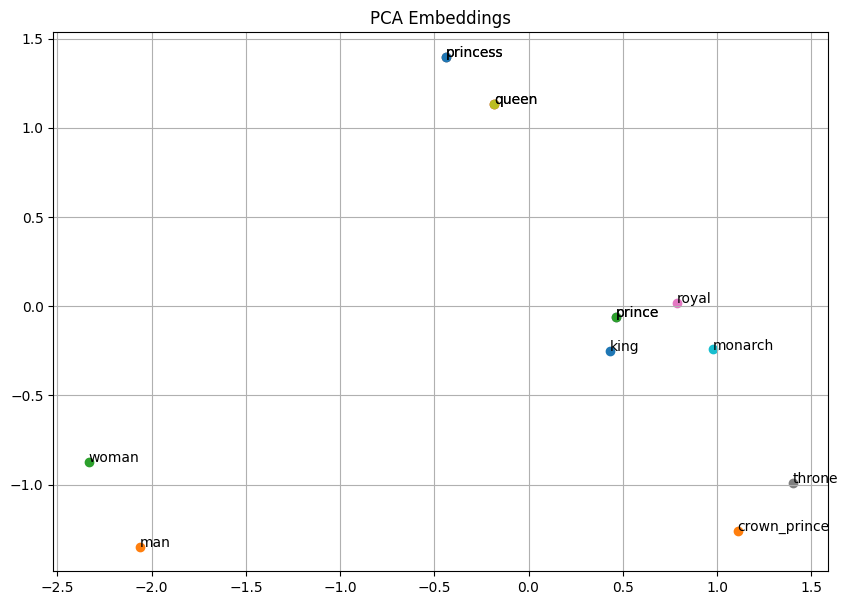

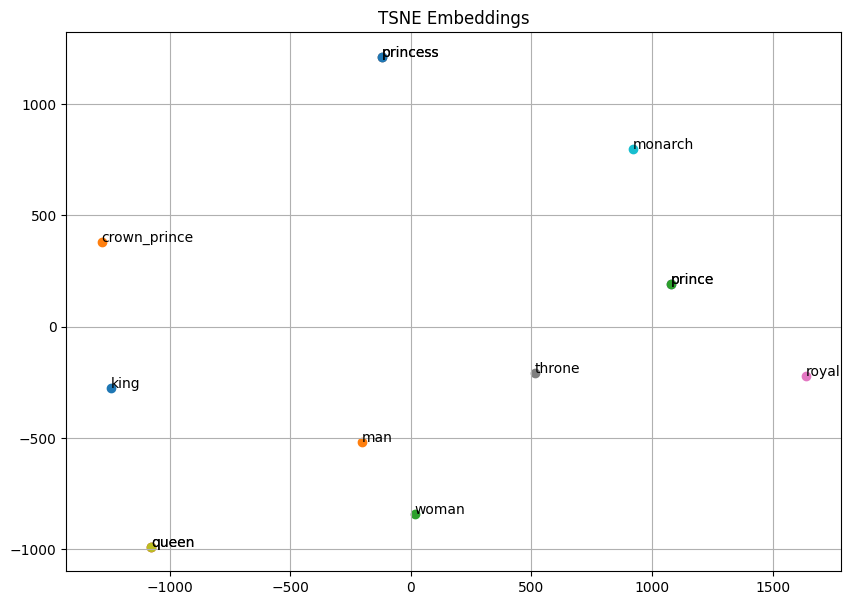

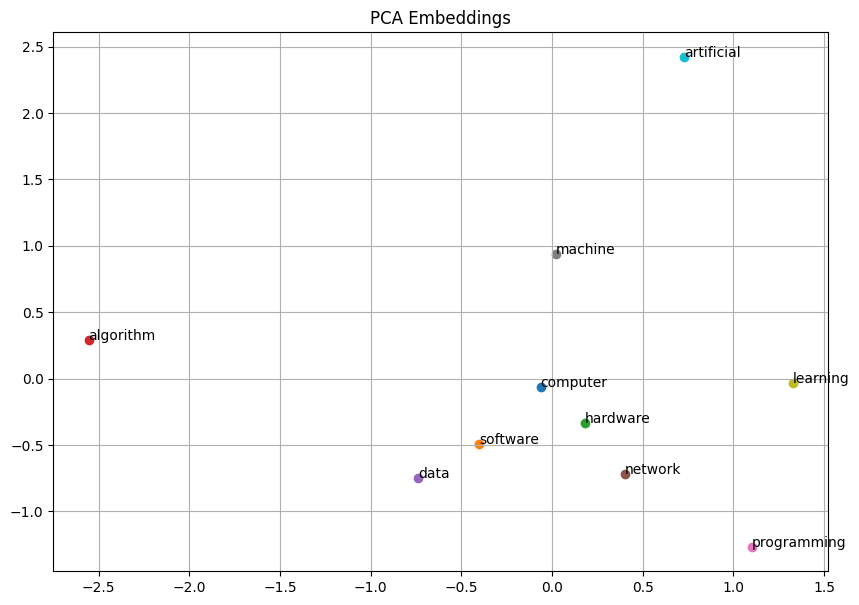

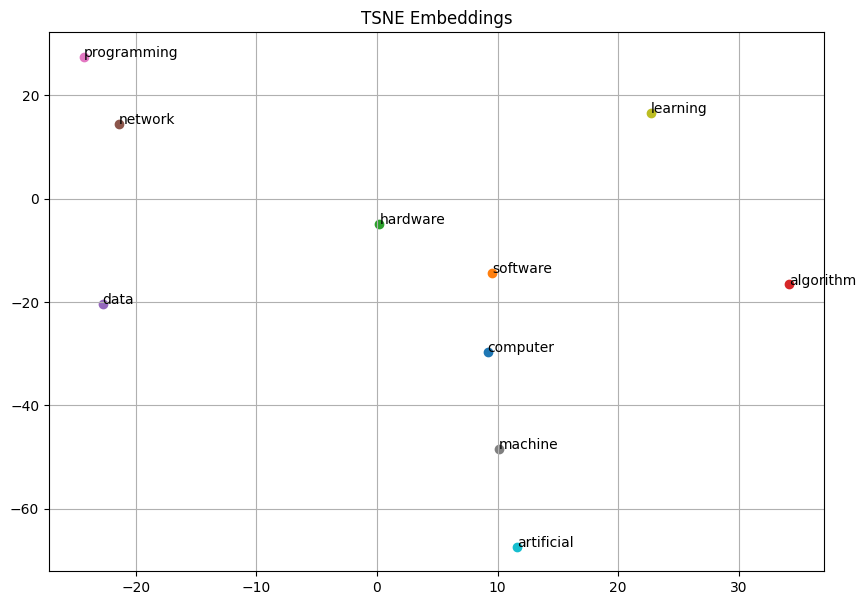


Similar to 'computer':
computers: 0.7979
laptop: 0.6640
laptop_computer: 0.6549
Computer: 0.6473
com_puter: 0.6082

Similar to 'learning':
teaching: 0.6602
learn: 0.6365
Learning: 0.6208
reteaching: 0.5810
learner_centered: 0.5739


In [ ]:
# Program 2
import gensim.downloader as api
import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

wv = api.load("word2vec-google-news-300")

def analogy(w1, w2, w3):  # word1 - word2 + word3
    try:
        res = wv.most_similar(positive=[w1, w3], negative=[w2], topn=5)
        print(f"\n{w1} - {w2} + {w3} ≈"); [print(f"{w}: {s:.4f}") for w, s in res]
        return [w for w, _ in res]
    except: return []

def plot(words, method='pca', perplexity=5):
    vecs = np.array([wv[w] for w in words])
    red = PCA(2) if method == 'pca' else TSNE(2, perplexity=perplexity)
    coords = red.fit_transform(vecs)
    plt.figure(figsize=(10, 7))
    [plt.scatter(*coords[i]) and plt.text(*coords[i], w) for i, w in enumerate(words)]
    plt.title(f"{method.upper()} Embeddings"); plt.grid(); plt.show()

def similar(w):
    try:
        print(f"\nSimilar to '{w}':"); [print(f"{x}: {s:.4f}") for x, s in wv.most_similar(w, topn=5)]
    except: print("Word not found.")

# --- Run ---
extra = analogy("king", "man", "woman")
royalty = ["king", "man", "woman", "queen", "prince", "princess", "royal", "throne"] + extra
plot(royalty, 'pca'); plot(royalty, 'tsne', 3)

tech = ["computer", "software", "hardware", "algorithm", "data", "network",
        "programming", "machine", "learning", "artificial"]
plot(tech, 'pca'); plot(tech, 'tsne', 3)
similar("computer"); similar("learning")


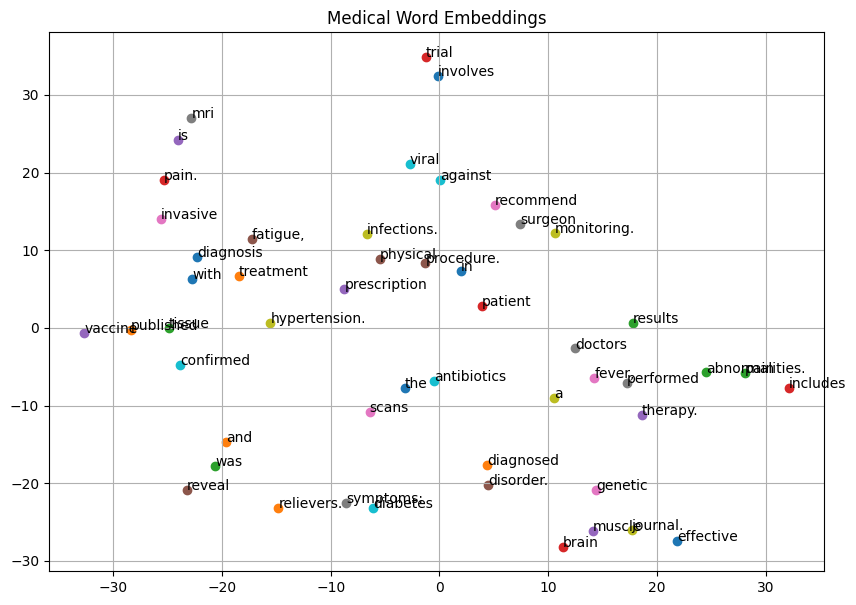


Similar to 'treatment':
diagnosis: 0.18
tissue: 0.17
fatigue,: 0.17
pain: 0.16
infections.: 0.14

Similar to 'vaccine':
published: 0.19
effective: 0.16
results: 0.16
involves: 0.10
prescription: 0.09


In [ ]:
# Program 3
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Medical corpus
corpus = [
    "The patient was diagnosed with diabetes and hypertension.",
    "MRI scans reveal brain tissue abnormalities.",
    "Treatment involves antibiotics and monitoring.",
    "Symptoms: fever, fatigue, muscle pain.",
    "Vaccine is effective against viral infections.",
    "Doctors recommend physical therapy.",
    "Trial results published in the journal.",
    "Surgeon performed invasive procedure.",
    "Prescription includes pain relievers.",
    "Diagnosis confirmed a genetic disorder."
]

# Train model
tokens = [s.lower().split() for s in corpus]
model = Word2Vec(tokens, vector_size=100, window=5, min_count=1, epochs=50)

# t-SNE visualization
words = model.wv.index_to_key
vecs = np.array([model.wv[w] for w in words])
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
reduced = tsne.fit_transform(vecs)

plt.figure(figsize=(10, 7))
for i, w in enumerate(words):
    plt.scatter(*reduced[i]); plt.text(*reduced[i], w)
plt.title("Medical Word Embeddings"); plt.grid(); plt.show()

# Similar words
for word in ["treatment", "vaccine"]:
    try:
        print(f"\nSimilar to '{word}':")
        for w, s in model.wv.most_similar(word, topn=5):
            print(f"{w}: {s:.2f}")
    except KeyError:
        print(f"{word} not found.")


In [ ]:
# Program 4
# Install: pip install gensim transformers nltk
import gensim.downloader as api
from transformers import pipeline
import nltk, string
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# Load models
wv = api.load("glove-wiki-gigaword-100")
generator = pipeline("text-generation", model="gpt2")

def enrich_prompt(prompt, keyword):
    tokens = word_tokenize(prompt)
    enriched = []
    for word in tokens:
        clean = word.lower().strip(string.punctuation)
        if clean == keyword.lower():
            try:
                sim = wv.most_similar(clean, topn=1)[0][0]
                print(f"Replacing '{word}' → '{sim}'")
                enriched.append(sim)
                continue
            except: pass
        enriched.append(word)
    return " ".join(enriched)

def generate(prompt):
    try: return generator(prompt, max_length=50)[0]['generated_text']
    except: return "Generation failed."

# Run
orig = "Who is king."
print(f"\nOriginal Prompt: {orig}")
enriched = enrich_prompt(orig, "king")
print(f"Enriched Prompt: {enriched}")

r1 = generate(orig)
r2 = generate(enriched)

print("\nOriginal Response:\n", r1)
print("\nEnriched Response:\n", r2)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Original Prompt: Who is king.
Replacing 'king' → 'prince'
Enriched Prompt: Who is prince .


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Original Response:
 Who is king.

I will not tell you that I am king.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am woman.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am woman.

I will not tell you that I am man.

I will not tell you that I am woman.

I will not tell you that I am woman.

I will not tell you that I am man.

I will

Enriched Response:
 Who is prince ...?" And he answered: "No one has ever seen a prince.

"Where is he, then?" asked the prince.

"I never heard of him," replied the prince, "but

In [ ]:
# Program 5
import gensim.downloader as api
import random

model = api.load("glove-wiki-gigaword-100")

def generate_paragraph(seed):
    try:
        words = [w for w, _ in model.most_similar(seed, topn=5)]
    except KeyError:
        return "Seed word not found."

    templates = [
        f"The {seed} was surrounded by {words[0]} and {words[1]}.",
        f"People associate {seed} with {words[2]} and {words[3]}.",
        f"In the land of {seed}, {words[4]} was common.",
        f"A story about {seed} needs {words[1]} and {words[3]}."
    ]
    return " ".join(random.choices(templates, k=3))

# Run
seed = input("Enter a seed word: ")
print("\nGenerated Paragraph:\n" + generate_paragraph(seed))


Enter a seed word: ocean

Generated Paragraph:
The ocean was surrounded by sea and waters. In the land of ocean, atlantic was common. People associate ocean with seas and coast.


In [ ]:
# Program 6
from transformers import pipeline

print("🔍 Loading Sentiment Analysis Model...")
analyze = pipeline("sentiment-analysis")

reviews = [
    "The product is amazing! I love it so much.",
    "I'm very disappointed. The service was terrible.",
    "It was an average experience, nothing special.",
    "Absolutely fantastic quality! Highly recommended.",
    "Not great, but not the worst either."
]

print("\n📢 Customer Sentiment Analysis Results:")
for text in reviews:
    result = analyze(text)[0]
    print(f"\n📝 Input Text: {text}")
    print(f"📊 Sentiment: {result['label']} (Confidence: {result['score']:.4f})")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


🔍 Loading Sentiment Analysis Model...


Device set to use cpu



📢 Customer Sentiment Analysis Results:

📝 Input Text: The product is amazing! I love it so much.
📊 Sentiment: POSITIVE (Confidence: 0.9999)

📝 Input Text: I'm very disappointed. The service was terrible.
📊 Sentiment: NEGATIVE (Confidence: 0.9998)

📝 Input Text: It was an average experience, nothing special.
📊 Sentiment: NEGATIVE (Confidence: 0.9995)

📝 Input Text: Absolutely fantastic quality! Highly recommended.
📊 Sentiment: POSITIVE (Confidence: 0.9999)

📝 Input Text: Not great, but not the worst either.
📊 Sentiment: NEGATIVE (Confidence: 0.9961)


In [ ]:
# Program 7
from transformers import pipeline

print("🔍 Loading Summarization Model (BART)...")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(text):
    text = " ".join(text.split())
    settings = {
        "Default": {},
        "High randomness": {"do_sample": True, "temperature": 0.9},
        "Conservative": {"do_sample": False, "num_beams": 5},
        "Diverse sampling": {"do_sample": True, "top_k": 50, "top_p": 0.95},
    }

    print("\n📝 Original Text:\n", text)
    print("\n📌 Summarized Text:")
    for label, params in settings.items():
        summary = summarizer(text, max_length=150, min_length=30, **params)[0]['summary_text']
        print(f"{label}: {summary}")

# Example input
long_text = """
Artificial Intelligence (AI) is a rapidly evolving field of computer science focused on creating intelligent machines
capable of mimicking human cognitive functions such as learning, problem-solving, and decision-making.
In recent years, AI has significantly impacted various industries, including healthcare, finance, education,
and entertainment. AI-powered applications, such as chatbots, self-driving cars, and recommendation systems,
have transformed the way we interact with technology. Machine learning and deep learning, subsets of AI,
enable systems to learn from data and improve over time without explicit programming.
However, AI also poses ethical challenges, such as bias in decision-making and concerns over job displacement.
As AI technology continues to advance, it is crucial to balance innovation with ethical considerations to ensure
its responsible development and deployment.
"""

# Run summarization
summarize_text(long_text)


🔍 Loading Summarization Model (BART)...


Device set to use cpu



📝 Original Text:
 Artificial Intelligence (AI) is a rapidly evolving field of computer science focused on creating intelligent machines capable of mimicking human cognitive functions such as learning, problem-solving, and decision-making. In recent years, AI has significantly impacted various industries, including healthcare, finance, education, and entertainment. AI-powered applications, such as chatbots, self-driving cars, and recommendation systems, have transformed the way we interact with technology. Machine learning and deep learning, subsets of AI, enable systems to learn from data and improve over time without explicit programming. However, AI also poses ethical challenges, such as bias in decision-making and concerns over job displacement. As AI technology continues to advance, it is crucial to balance innovation with ethical considerations to ensure its responsible development and deployment.

📌 Summarized Text:
Default: Artificial Intelligence (AI) is a rapidly evolving fie

In [ ]:
# Program 8
# API keys:-
# note: keys are rate-limited, please don't abuse them by spamming re-runs, stick to one key if it works, let others use the rest
# anshul's default (active): "aOfQejL0g9kwJonxagB01lxOjuu41ETByZrG70n7"
# anshul's testing-1 (active): "uOg8fNJyr27I4hfXCxjKGyiD5ZQZWWd8nRhFqbAV"
# anshul's testing-2 (active): "KhNE3Ppu3oxfIaG5JWizZuKU15JsAkmtaLSmtWLR"
# abhinav pandey's key (status unknown): "dR3tDPkjm3ZgfzBS3qCxMKviN2MIA8MeECoUZcNs"
import getpass
from langchain.llms import Cohere
from langchain import PromptTemplate
from google.colab import auth, drive

auth.authenticate_user()
drive.mount('/content/drive')

with open("/content/GIS_IMp.txt", "r", encoding="utf-8") as f:
    text = f.read()

llm = Cohere(cohere_api_key=getpass.getpass("🔑 Enter Cohere API Key: "), model="command")

prompt = PromptTemplate(
    input_variables=["text"],
    template="""
You are an AI assistant helping to summarize and analyze a text document.
Here is the document content:

{text}

🔹 Summary: Provide a concise summary.
🔹 Key Takeaways: List 3 key points.
🔹 Sentiment Analysis: Positive, Negative, or Neutral.
"""
)

print("\n📌 Output:\n", llm.predict(prompt.format(text=text)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔑 Enter Cohere API Key: ··········

📌 Output:
  

Summary: The text document provides a collection of GIS troubleshooting steps and metadata on raster image data, bands, and spatial analysis types. 

Key Takeaways: 

1. For separating state boundaries from other boundaries, use the *Add the layers* > *Extract by attribute* option to make a separate file, or use *Select by attribute* to merely highlight the selection. 

2. To reproject a layer, you can utilize the *Search* tool, selecting *Reproject layer*. You can then save it as a *.shp file*. 

3. For Landsat data, understand that it comprises 11 bands, while Sentinel has 13 bands. To identify vegetation, you specifically employ Sentinel Band 3 and 4. 

Sentiment Analysis: Neutral



I hope these summary points help! Let me know if you require further clarification on any of the steps, or if you'd like me t

In [ ]:
# Program 9
# from pydantic import BaseModel
# from typing import List, Optional
# import wikipediaapi, ipywidgets as widgets
# from IPython.display import display

# class InstitutionDetails(BaseModel):
#     founder: Optional[str]
#     founded: Optional[str]
#     branches: Optional[List[str]]
#     number_of_employees: Optional[int]
#     summary: Optional[str]

# def fetch_institution_details(name: str) -> InstitutionDetails:
#     page = wikipediaapi.Wikipedia(user_agent="Notebook/1.0 (contact: myemail@example.com)", language='en').page(name)
#     if not page.exists(): raise ValueError(f"No page found for '{name}'")

#     founder = founded = None
#     branches = []; summary = page.summary[:500]; num_employees = None
#     for line in page.text.split('\n'):
#         if 'Founder' in line: founder = line.split(':')[-1].strip()
#         elif 'Founded' in line: founded = line.split(':')[-1].strip()
#         elif 'Branches' in line: branches = [b.strip() for b in line.split(':')[-1].split(',')]
#         elif 'Number of employees' in line:
#             try: num_employees = int(line.split(':')[-1].strip().replace(',', ''))
#             except: pass

#     return InstitutionDetails(
#         founder=founder, founded=founded,
#         branches=branches or None,
#         number_of_employees=num_employees, summary=summary
#     )

# def display_details(d: InstitutionDetails):
#     print(f"Founder: {d.founder or 'N/A'}")
#     print(f"Founded: {d.founded or 'N/A'}")
#     print(f"Branches: {', '.join(d.branches) if d.branches else 'N/A'}")
#     print(f"Employees: {d.number_of_employees or 'N/A'}")
#     print(f"Summary: {d.summary or 'N/A'}")

# text_box = widgets.Text(placeholder='Enter institution name', description='Institution:')
# button = widgets.Button(description='Fetch Details', icon='search')
# button.on_click(lambda b: display_details(fetch_institution_details(text_box.value)) if text_box.value else print("Please enter a name."))
# display(text_box, button)

from pydantic import BaseModel
from typing import List, Optional
import wikipediaapi

class InstitutionDetails(BaseModel):
    founder: Optional[str]
    founded: Optional[str]
    branches: Optional[List[str]]
    number_of_employees: Optional[int]
    summary: Optional[str]

def fetch_institution_details(name: str) -> InstitutionDetails:
    wiki = wikipediaapi.Wikipedia(
        user_agent="VSCodeScript/1.0 (contact: myemail@example.com)", language='en'
    )
    page = wiki.page(name)
    if not page.exists():
        raise ValueError(f"No page found for '{name}'")

    founder = founded = None
    branches = []
    summary = page.summary[:500]
    num_employees = None

    for line in page.text.split('\n'):
        if 'Founder' in line:
            founder = line.split(':')[-1].strip()
        elif 'Founded' in line:
            founded = line.split(':')[-1].strip()
        elif 'Branches' in line:
            branches = [b.strip() for b in line.split(':')[-1].split(',')]
        elif 'Number of employees' in line:
            try:
                num_employees = int(line.split(':')[-1].strip().replace(',', ''))
            except ValueError:
                pass

    return InstitutionDetails(
        founder=founder,
        founded=founded,
        branches=branches or None,
        number_of_employees=num_employees,
        summary=summary
    )

def display_details(d: InstitutionDetails):
    print(f"\n--- Institution Details ---")
    print(f"Founder: {d.founder or 'N/A'}")
    print(f"Founded: {d.founded or 'N/A'}")
    print(f"Branches: {', '.join(d.branches) if d.branches else 'N/A'}")
    print(f"Employees: {d.number_of_employees or 'N/A'}")
    print(f"Summary: {d.summary or 'N/A'}\n")

if __name__ == "__main__":
    institution_name = input("Enter institution name: ").strip()
    if institution_name:
        try:
            details = fetch_institution_details(institution_name)
            display_details(details)
        except ValueError as e:
            print(e)
    else:
        print("Please enter a valid institution name.")


Enter institution name: RVCE

--- Institution Details ---
Founder: N/A
Founded: N/A
Branches: N/A
Employees: N/A
Summary: Rashtreeya Vidyalaya College of Engineering (RVCE or RV College of Engineering) is an autonomous private engineering college in Bangalore, Karnataka, India. It was established in 1963 under the Rashtreeya Sikshana Samithi Trust (RSST) and was one of the earliest self-financing engineering colleges in the country. It is affiliated with the Visvesvaraya Technological University, Belgaum. In 2008, the college was given autonomous status.



In [ ]:
# Program 10
from langchain import PromptTemplate, LLMChain
from langchain.llms import Cohere
from pydantic import BaseModel
from typing import Optional
import wikipediaapi
import getpass
# API keys:-
# note: keys are rate-limited, please don't abuse them by spamming re-runs, stick to one key if it works, let others use the rest
# anshul's default (active): "aOfQejL0g9kwJonxagB01lxOjuu41ETByZrG70n7"
# anshul's testing-1 (active): "uOg8fNJyr27I4hfXCxjKGyiD5ZQZWWd8nRhFqbAV"
# anshul's testing-2 (active): "KhNE3Ppu3oxfIaG5JWizZuKU15JsAkmtaLSmtWLR"
# abhinav pandey's key (status unknown): "dR3tDPkjm3ZgfzBS3qCxMKviN2MIA8MeECoUZcNs"
# Step 1: Set up the Cohere API
COHERE_API_KEY = getpass.getpass('Enter your Cohere API Key: ')
cohere_llm = Cohere(cohere_api_key=COHERE_API_KEY, model="command")

# Step 2: Download Indian Penal Code (IPC) summary from Wikipedia
def fetch_ipc_summary() -> str:
    wiki = wikipediaapi.Wikipedia(
        user_agent="IPCChatbot/1.0 (contact: myemail@example.com)", language='en'
    )
    page = wiki.page("Indian Penal Code")
    if not page.exists():
        raise ValueError("The Indian Penal Code page does not exist on Wikipedia.")
    return page.text[:5000]  # Limit to first 5000 characters

ipc_content = fetch_ipc_summary()

# Step 3: Define a Pydantic model for structured responses
class IPCResponse(BaseModel):
    section: Optional[str]
    explanation: Optional[str]

# Step 4: Create a prompt template for the chatbot
prompt_template = PromptTemplate(
    input_variables=["question"],
    template="""
You are a legal assistant chatbot specialized in the Indian Penal Code (IPC).
Refer to the following IPC document content to answer the user's query:

{ipc_content}

User Question: {question}

Provide a detailed answer, mentioning the relevant section if applicable.
"""
)

# Step 5: Function to get IPC response
def get_ipc_response(question: str) -> IPCResponse:
    prompt = prompt_template.format(ipc_content=ipc_content, question=question)
    response = cohere_llm.predict(prompt)

    if "Section" in response:
        section_part = response.split('Section', 1)[1]
        section = section_part.split(':')[0].strip()
        explanation = section_part.split(':', 1)[-1].strip()
    else:
        section = None
        explanation = response.strip()

    return IPCResponse(section=section, explanation=explanation)

# Step 6: Command-line chatbot loop
def main():
    print("IPC Legal Assistant Chatbot (type 'exit' to quit)\n")
    while True:
        question = input("You: ").strip()
        if question.lower() in ['exit', 'quit']:
            print("Goodbye!")
            break
        if question:
            try:
                response = get_ipc_response(question)
                print(f"\nSection: {response.section or 'N/A'}")
                print(f"Explanation: {response.explanation}\n")
            except Exception as e:
                print(f"Error: {e}\n")
        else:
            print("Please enter a valid question.\n")

if __name__ == "__main__":
    main()



Enter your Cohere API Key: ··········


<ipython-input-3-5d183e31691c>:11: LangChainDeprecationWarning: The class `Cohere` was deprecated in LangChain 0.1.14 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-cohere package and should be used instead. To use it run `pip install -U :class:`~langchain-cohere` and import as `from :class:`~langchain_cohere import Cohere``.
  cohere_llm = Cohere(cohere_api_key=COHERE_API_KEY, model="command")


IPC Legal Assistant Chatbot (type 'exit' to quit)

You: Section 45


<ipython-input-3-5d183e31691c>:48: LangChainDeprecationWarning: The method `BaseLLM.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = cohere_llm.predict(prompt)



Section: 45 deals with the punishment for malicious injury to property. Below is the detailed answer explaining the specifics of this section
Explanation: In accordance with Section 45 of the Indian Penal Code, 1860, anyone who maliciously injures or defiles any property belonging to another person shall be punished with imprisonment of either description for a term which may extend to three years, or with a fine, or with both. This provision implies that any willful or purposely inflicted damage to another person's property could result in criminal liability. 

This section specifies that the act must be committed maliciously, meaning the offender intentionally caused harm or damage to the property with an unlawful or guilty intention. However, if the offender can prove that the damage or injury was accidentally or unintentionally caused, they may be exempt from punishment. 

Please note that this is the official criminal code of India, and though it was replaced by the Bharatiya Nya

VIVA

----
1. What is the significance of Cohere, LangChain, and Pydantic?

- Cohere: Provides NLP APIs including embeddings, classification, and summarization via LLMs. Used for model inference.

- LangChain: Framework to build applications powered by LLMs. It connects LLMs with tools like memory, APIs, and agents.

- Pydantic: Used for data validation and parsing using Python type hints. Useful in defining schemas and ensuring structured output from LLMs.

----

2. Explain the techniques used in word embeddings.

- Traditional: One-hot encoding, Bag of Words (BoW), TF-IDF.

- Neural: Word2Vec (CBOW, Skip-gram), GloVe (co-occurrence matrix), FastText (subword n-grams), BERT (contextual embeddings).

----

3. Why do we use word embeddings?/ Need for word embeddings.

- To reduce dimensionality and sparsity.

- To capture semantic and syntactic meanings.

- To enable words with similar meanings to have similar representations.

----

4. Discuss the real-world applications of LLMs and their limitations.

- Applications: Chatbots, summarization, code generation, sentiment analysis, content creation.

- Limitations: Bias in training data, hallucination, high computational cost, lack of real-time awareness.

----

5. Which model is used for summarization?

- Pre-trained summarization model from Hugging Face (facebook/bart-large-cnn)

----

6. Explain the BART model in detail.

- BART (Bidirectional and Auto-Regressive Transformer) combines BERT (encoding) and GPT (decoding).

- It is a sequence-to-sequence model used for text generation, summarization, translation, etc.

- Trained by corrupting text and learning to reconstruct it.

----

7. What is sentiment analysis and its applications?

- It is the process of identifying sentiment (positive, negative, neutral) from text.

- Applications: Customer feedback, brand monitoring, political analysis, market research.

----

8. Discuss and explain the significance of the parameter perplexity in t-SNE.

- hyperparameter that defines the effective number of neighbors.

- Controls the balance between local(less perplexity) vs. global(more perplexity) structure.

- Should be less than the number of data points; typical range: 5–50.

----

9. Describe the algorithm (step-by-step, in words) for building an IPC chatbot.

a. Download the Indian Penal Code document.

b. Preprocess and split the document into retrievable chunks.

c. Use embeddings to store the chunks in a vector store.

d. Accept user queries.

e. Retrieve relevant sections using similarity search.

f. Use LLM (via LangChain) to answer based on the retrieved context.

----

10. Discuss PCA and t-SNE.

- PCA: Linear, preserves global variance, faster, used for large datasets.

- t-SNE: Non-linear, preserves local relationships, ideal for visualizing word clusters in small data.

- Used to visualize high-dimensional word embeddings in 2D/3D.

----

11. What are the uses of prompt engineering?

- To control LLM outputs by carefully designing the input prompts.

- Used in chatbots, summarization, translation, data extraction, and few-shot learning.

----